In [1]:
import requests
import time # import for playing nice and not getting blocked
import pandas as pd
# from BeautifulSoup4 import BeatifulSoup if installed through pip install BeautifulSoup4
# 
from bs4 import BeautifulSoup

In [2]:
# lets combine the above cells into a function which will always get us columns
def getColList(soup):
    column_list = ["description","url"] # we decided to that we need these two column names no matter the html
    headline = soup.find("tr", {"id":"head_line"})
    headtds = headline.find_all("td")
    headcolumns = [el.text for el in headtds[1:]] # this will get all column names starting with 2nd in HTML
    column_list += headcolumns
    return column_list

# lets make a function from the above doodle and make it work on most pages on SS
def getRowList(soup):
    trows = soup.find_all('tr')
    aprows = [row for row in trows if row.get('id',"").startswith("tr_") and not row.get('id',"").startswith("tr_bnr") ]
    return aprows

def getRow(row,colist):
    row_tds = row.find_all('td')
    rowDict = {}
    if len(row_tds) < 3: # a little sanity check
        print("Hmm bad row")
        return rowDict
    
    rowDict[colist[0]] = row_tds[2].text # so the big assumption is that we always get description in 3rd column
    rowDict[colist[1]] = "https://ss.com" + row_tds[1].find('a').get('href')
    for td,key in zip(row_tds[3:],colist[2:]): 
        rowDict[key] = td.text
    return rowDict

# so if we know how to work on single row then we can do process multiple rows
def getRows(rowlist,colist):
    return [getRow(row, colist=colist) for row in rowlist] # so return a list of dictionaries

# so with this function I can get full dataframe from a single page on ss.com not only apartments
def getDFfromURL(url):
    # print("getting data from", url)
    req = requests.get(url)
    if req.status_code != 200:
        print("Request Fail with", req.status_code)
        return None # maybe return empty dataframe here
    soup = BeautifulSoup(req.text, 'lxml')
    column_names = getColList(soup)
    rowlist = getRowList(soup)
    rows = getRows(rowlist,colist=column_names)
    return pd.DataFrame(rows, columns=column_names)

def getAllLocalUrls(url):
    """Get a list of all urls including paginated pages"""
    results = [url] # default is just the url if no extra pages found, teiksim Bolderājai...
    req = requests.get(url)
    if req.status_code != 200:
        print(f"Bad response! {req.status_code}")
        return []
    soup = BeautifulSoup(req.text, 'lxml')
    # we just need a one element
    prevanchor = soup.find('a', {"rel":"prev"}) # find finds first match only
    if prevanchor == None: # means there is only one page of ads
        return results
    href = prevanchor.attrs.get('href')
    lastPageNum = int(href.split('/page')[-1].split('.html')[0])
    print("Last page is",lastPageNum)
    nurls = [f"{url}page{n}.html" for n in range(2,lastPageNum+1)]
    results += nurls
    return results

def get_all_ads_df(start_url, save_excel_path=None):
    df_list=[] # so we will save our dataframes in a list
    local_urls = getAllLocalUrls(start_url)
    for url in local_urls:
        print(f"Gathering data from {url}")
        df_list.append(getDFfromURL(url))
        time.sleep(0.3) # we need this to play nice! to avoid rate limit or IP ban!!
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html
    big_df = pd.concat(df_list) # then make a big dataframe from all the small dataframes
    if save_excel_path:
        big_df.to_excel(save_excel_path)
    return big_df

In [3]:
imanta = "https://www.ss.com/lv/real-estate/flats/riga/imanta/sell/"

In [4]:
df = get_all_ads_df(imanta, "imanta_10_11.xlsx")
df.head()

Last page is 3
Gathering data from https://www.ss.com/lv/real-estate/flats/riga/imanta/sell/
Gathering data from https://www.ss.com/lv/real-estate/flats/riga/imanta/sell/page2.html
Gathering data from https://www.ss.com/lv/real-estate/flats/riga/imanta/sell/page3.html


,description,url,Iela,Ist.,m2,Stāvs,Sērija,"Cena, m2",Cena
0,"Istabas izolētas, liela lodžija. \r\nIeeja ar ...",https://ss.com/msg/lv/real-estate/flats/riga/i...,Rigondas g. 7,2,49,10/12,Čehu pr.,"1,163 €","57,000 €"
1,"Pārdodu gaišu, siltu, pilnībā izremontētu mēbe...",https://ss.com/msg/lv/real-estate/flats/riga/i...,Imantas 2,2,50,2/5,LT proj.,"1,280 €","64,000 €"
2,Pārdod saulainu dzīvokli ar mēbelēm un tehniku...,https://ss.com/msg/lv/real-estate/flats/riga/i...,Imantas 6a,2,50,4/5,LT proj.,"1,336 €","66,800 €"
3,"Pārdodu 2 istabu dzīvokli mūsdienu projekta ""M...",https://ss.com/msg/lv/real-estate/flats/riga/i...,Anniņmuižas 38k1,2,58,2/18,Jaun.,"1,716 €","99,500 €"
4,Редкое предложение в Иманте: 2-комнатная кварт...,https://ss.com/msg/lv/real-estate/flats/riga/i...,Progresa 2a,2,56,2/12,104.,"1,063 €","59,500 €"


In [5]:
df[['Floor','MaxFloor']] = df.Stāvs.str.split("/",expand=True) 
df.Floor = df.Floor.astype('int32')
df.MaxFloor = df.MaxFloor.astype('int32')
df.head()

,description,url,Iela,Ist.,m2,Stāvs,Sērija,"Cena, m2",Cena,Floor,MaxFloor
0,"Istabas izolētas, liela lodžija. \r\nIeeja ar ...",https://ss.com/msg/lv/real-estate/flats/riga/i...,Rigondas g. 7,2,49,10/12,Čehu pr.,"1,163 €","57,000 €",10,12
1,"Pārdodu gaišu, siltu, pilnībā izremontētu mēbe...",https://ss.com/msg/lv/real-estate/flats/riga/i...,Imantas 2,2,50,2/5,LT proj.,"1,280 €","64,000 €",2,5
2,Pārdod saulainu dzīvokli ar mēbelēm un tehniku...,https://ss.com/msg/lv/real-estate/flats/riga/i...,Imantas 6a,2,50,4/5,LT proj.,"1,336 €","66,800 €",4,5
3,"Pārdodu 2 istabu dzīvokli mūsdienu projekta ""M...",https://ss.com/msg/lv/real-estate/flats/riga/i...,Anniņmuižas 38k1,2,58,2/18,Jaun.,"1,716 €","99,500 €",2,18
4,Редкое предложение в Иманте: 2-комнатная кварт...,https://ss.com/msg/lv/real-estate/flats/riga/i...,Progresa 2a,2,56,2/12,104.,"1,063 €","59,500 €",2,12


In [6]:
max_floor = df['Floor'].max()
print("Highest available floor: ", max_floor)

Highest available floor:  15


In [7]:
df["price"] = df.Cena.str.replace(",","").str.split(' ').str[0].astype('int32')
df.head()


,description,url,Iela,Ist.,m2,Stāvs,Sērija,"Cena, m2",Cena,Floor,MaxFloor,price
0,"Istabas izolētas, liela lodžija. \r\nIeeja ar ...",https://ss.com/msg/lv/real-estate/flats/riga/i...,Rigondas g. 7,2,49,10/12,Čehu pr.,"1,163 €","57,000 €",10,12,57000
1,"Pārdodu gaišu, siltu, pilnībā izremontētu mēbe...",https://ss.com/msg/lv/real-estate/flats/riga/i...,Imantas 2,2,50,2/5,LT proj.,"1,280 €","64,000 €",2,5,64000
2,Pārdod saulainu dzīvokli ar mēbelēm un tehniku...,https://ss.com/msg/lv/real-estate/flats/riga/i...,Imantas 6a,2,50,4/5,LT proj.,"1,336 €","66,800 €",4,5,66800
3,"Pārdodu 2 istabu dzīvokli mūsdienu projekta ""M...",https://ss.com/msg/lv/real-estate/flats/riga/i...,Anniņmuižas 38k1,2,58,2/18,Jaun.,"1,716 €","99,500 €",2,18,99500
4,Редкое предложение в Иманте: 2-комнатная кварт...,https://ss.com/msg/lv/real-estate/flats/riga/i...,Progresa 2a,2,56,2/12,104.,"1,063 €","59,500 €",2,12,59500


<AxesSubplot:>

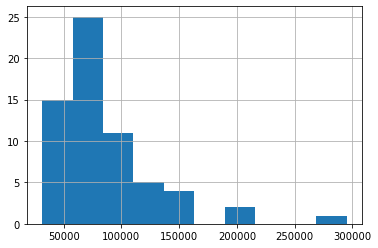

In [8]:
df.price.hist()

In [9]:
gr_imanta_price = df.groupby("Sērija")["price"].agg(["count", "min", "max", "mean"]) 
gr_imanta_price

,count,min,max,mean
Sērija,,,,
104.,1,59500,59500,59500.000000
467.,1,61000,61000,61000.000000
602.,23,31400,84000,62295.652174
Jaun.,19,82900,294950,138797.368421
LT proj.,13,40000,96000,59492.307692
Specpr.,5,55500,115000,93300.000000
Čehu pr.,1,57000,57000,57000.000000


In [10]:
vw_url = "https://www.ss.com/lv/transport/cars/volkswagen/sell/"
df_vw = get_all_ads_df(vw_url, "vw_10_11.xlsx")

Last page is 79
Gathering data from https://www.ss.com/lv/transport/cars/volkswagen/sell/
Gathering data from https://www.ss.com/lv/transport/cars/volkswagen/sell/page2.html
Gathering data from https://www.ss.com/lv/transport/cars/volkswagen/sell/page3.html
Gathering data from https://www.ss.com/lv/transport/cars/volkswagen/sell/page4.html
Gathering data from https://www.ss.com/lv/transport/cars/volkswagen/sell/page5.html
Gathering data from https://www.ss.com/lv/transport/cars/volkswagen/sell/page6.html
Gathering data from https://www.ss.com/lv/transport/cars/volkswagen/sell/page7.html
Gathering data from https://www.ss.com/lv/transport/cars/volkswagen/sell/page8.html
Gathering data from https://www.ss.com/lv/transport/cars/volkswagen/sell/page9.html
Gathering data from https://www.ss.com/lv/transport/cars/volkswagen/sell/page10.html
Gathering data from https://www.ss.com/lv/transport/cars/volkswagen/sell/page11.html
Gathering data from https://www.ss.com/lv/transport/cars/volkswagen/

In [11]:
df_vw.head()

,description,url,Modelis,Gads,Tilp.,Nobrauk.,Cena
0,Max pilna komplektācija/ 4 Motion/ Dsg/ Ziemas...,https://ss.com/msg/lv/transport/cars/volkswage...,Tiguan,2013,2.0D,218 tūkst.,"11,650 €"
1,Новый ТО и полностью оплачен налог. \r\nДизель...,https://ss.com/msg/lv/transport/cars/volkswage...,Touran,2003,2.0D,373 tūkst.,"2,500 €"
2,Pardod pasatu laba darba kartiba. \r\nnopietna...,https://ss.com/msg/lv/transport/cars/volkswage...,Passat (B5),1997,1.6,346 tūkst.,830 €
3,"VW Crafter L2H2, cena ar Pvn 21%. \r\n\r\nPirk...",https://ss.com/msg/lv/transport/cars/volkswage...,Crafter,2012,2.0D,-,"7,700 €"
4,"Pārdodu vw touareg 3.0 tdi 165kw 2006g, auto l...",https://ss.com/msg/lv/transport/cars/volkswage...,Touareg,2006,3.0D,211 tūkst.,"5,000 €"


In [12]:
df_vw["price"] = df_vw.head()["Cena"].str.replace(",","").str.split(' ').str[0].astype('int32')
df_vw.head()

,description,url,Modelis,Gads,Tilp.,Nobrauk.,Cena,price
0,Max pilna komplektācija/ 4 Motion/ Dsg/ Ziemas...,https://ss.com/msg/lv/transport/cars/volkswage...,Tiguan,2013,2.0D,218 tūkst.,"11,650 €",11650.0
1,Новый ТО и полностью оплачен налог. \r\nДизель...,https://ss.com/msg/lv/transport/cars/volkswage...,Touran,2003,2.0D,373 tūkst.,"2,500 €",2500.0
2,Pardod pasatu laba darba kartiba. \r\nnopietna...,https://ss.com/msg/lv/transport/cars/volkswage...,Passat (B5),1997,1.6,346 tūkst.,830 €,830.0
3,"VW Crafter L2H2, cena ar Pvn 21%. \r\n\r\nPirk...",https://ss.com/msg/lv/transport/cars/volkswage...,Crafter,2012,2.0D,-,"7,700 €",7700.0
4,"Pārdodu vw touareg 3.0 tdi 165kw 2006g, auto l...",https://ss.com/msg/lv/transport/cars/volkswage...,Touareg,2006,3.0D,211 tūkst.,"5,000 €",5000.0


In [13]:
df_vw_grp = df_vw.groupby("Modelis")["price"].agg(["count", "min", "max", "mean"]) 
df_vw_grp

,count,min,max,mean
Modelis,,,,
Amarok,8,830.0,11650.0,4526.250000
Arteon,0,NaN,NaN,NaN
Beetle,5,830.0,11650.0,7366.000000
Bora,4,5000.0,7700.0,6350.000000
Caddy,17,830.0,11650.0,4774.705882
Caravelle,8,830.0,11650.0,5332.500000
Citi,0,NaN,NaN,NaN
Crafter,11,830.0,11650.0,4900.909091
Eos,0,NaN,NaN,NaN


In [14]:
df_vw_grp.sort_values(by="count")

,count,min,max,mean
Modelis,,,,
Arteon,0,NaN,NaN,NaN
T6,0,NaN,NaN,NaN
T-Cross,0,NaN,NaN,NaN
Citi,0,NaN,NaN,NaN
Eos,0,NaN,NaN,NaN
Passat Alltrack,0,NaN,NaN,NaN
Up!,0,NaN,NaN,NaN
Passat (B2),0,NaN,NaN,NaN
Lupo,0,NaN,NaN,NaN
